# **Predicting quantity of users using shared bikes**

## **Introduction**

**Bike sharing is a recent trend that spread fast around the world.  It has a control system that gives an user a bike access for a determined time slot. The user get the bike and return to the same spot within the time slot. There are many advantages to go by bike, not only for reducing the traffick and poluition but also to get a healthier population. To the companies, it is indispensible to understand the users behaviour and manage their bikes to be always avaliable.** 





# **Businnes problem:**
### **Predict the number of bike rental per day based on the environmental and seasonal data**
#### **Methods**
#### 1. Data exploration and explotatory analysis
#### 2. Findind what factors impact on bike rentals
#### 3. Predict the number of bikes will be rented daily and hourly
____________________________________________________________________________________________________
----------------------------------------------------------------------------------------------------

# Understanding the dataset

**This dataset was kindly shared by Hadi Fanaee-T from 
Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Port**

**It was sampled both by day and by hour (file1 and file2**

- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual and registered: - both removed from the dataset because the sum is the total of counts
	- cnt: count of total rental bikes including both casual and registered

## **1. Data exploration and explotatory analysis**

In [40]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import itertools as it
from scipy import stats
from tqdm import tqdm
import seaborn as sns
import datetime as dt
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
file1 = 'bikes_day.csv'
# file1 it was the same data but sampled daily
file2= 'hour.csv'
# file2 was sampled by hour

In [6]:
class Data:
    """
    Data class to open and explore the data.
    
    Attributes
    ----------
    df (pandas datadrame): 
        Pandas dataframe containing the data
        
    target (str): 
        target column containing the dependent feature

    Methods
    ---------
    plot_correlation():
        Plot the correlation matrix
        
    summary(n=5):
        Summary of the dataframe.
    
    get_baseline_linear(plot=False, report=True, savefig=False):
        Runs linear models with all combinations of columns to automate feature selection
        
    """
    
    def __init__(self, file, target='cnt'):
        try:
            self.df = pd.read_csv(file, parse_dates=['dteday'])
        except:
            print('Could not read CSV file')
            
        self.df['dteday'] = pd.to_numeric(df.dteday)
        self.df.drop(['dteday', 'instant'], axis=1, inplace=True)
        self.target = target
    
    def drop(self, col):
       
        """
        drop function drop a column from the self.df  

        Parameters:
        arg1 (str): Name of the column to be removed

        Returns: None
        
        """
        self.df.drop(col, axis=1, inplace=True)
    
    def plot_correlation(self):
        
        """
        Plot the correlation matrix.

        Plot the correlation matrix from the dataframe self.df.

        Parameters: None

        Returns: None

        """
        corrMatrix = self.df.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corrMatrix, annot=False,  linewidths=1)
        plt.show()
        
    def summary(self, n=5):
        
        """
        Summary of the dataframe.

        Print info, dtypes, describe and the number of null values from the dataframe self.df.

        Parameters:
        n (int): The number of rows to be used in .head function

        Returns: None
        """
        print('-------------- Information about the data ---------------------\n')
        print(self.df.info())
        print('\n----------------------- Data types ----------------------------\n')
        print(self.df.dtypes)
        print('\n--------------------- Data describe ---------------------------\n')
        print(self.df.describe())
        print('\n-------------------- Data null values --------------------------\n')
        print(self.df.isnull().sum())       
        print('\n----------------------- Data head -----------------------------\n')
        return(self.df.head())

    
    def get_baseline_linear(self, plot=False, report=True, savefig=False):
        
        """
        Runs linear model

        Runs linear models with all combinations of columns to automate feature selection

        Parameters:
        plot (bool): True/False for ploting best model result against expected data 
        report (bool): True/False for printing the columns used in the best model and validation and test scores
        savefig (bool): True/False for saving plot
        
        Returns:
        dict: Values of validation and test of the best model

        """
        
        y = self.df[self.target]
        columns = self.df.drop(self.target, axis=1).columns
        val_r2 = 0
        test_r2 = 0
        
        for i in tqdm(range(1, len(columns)-1)):
            # try to find the best combination of columns
            for x in it.combinations(columns, i):
                X = self.df[list(x)]
                
                # Separate into train, validation and test
                X_train, X_test_val, y_train, y_test_val = train_test_split(X.values, y.values, test_size=.33, random_state=42)
                X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=.33, random_state=42)
                # run mode;
                model = LinearRegression().fit(X_train, y_train)
                pred_y = model.predict(X_val)
                r2 = r2_score(y_val, pred_y)
                pred_y = model.predict(X_test)
                if r2_score(y_test, pred_y) > test_r2:
                    val_r2 = r2
                    test_r2 = r2_score(y_test, pred_y)
                    cols = x
                    
        if plot:
            # Plot result
            x_ax = range(len(y_test[-80:]))
            plt.plot(x_ax, y_test[-80:], label="original")
            plt.plot(x_ax, pred_y[-80:], label="predicted")
            plt.title(f'Bike sharing predicted r2: {test_r2:.2f} ')
            plt.legend()
            if savefig:
                plt.savefig(f'model_baseile.png')
            plt.show()
            
        if report:
            print(f'Best columns for regression: {cols}')
            print(f'Validation score: {val_r2},\t Test score: {test_r2}\ntested in {len(X_test)} data points')
        
        return {'val':val_r2, 'test': test_r2}
        

In [7]:
# Read file 1 data sampled daily
df = pd.read_csv(file1, parse_dates=['dteday'])
df.drop('instant', inplace=True, axis=1)
data = Data(file1)

#### **Verify data quality**

In [8]:
data.summary(n=3)

-------------- Information about the data ---------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   atemp       731 non-null    float64
 9   hum         731 non-null    float64
 10  windspeed   731 non-null    float64
 11  cnt         731 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.7 KB
None

----------------------- Data types ----------------------------

season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
we

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [9]:
# Correct catogorical types
cat_columns = [ 'season', 'holiday', 'weekday', 'workingday', 'weathersit']
target = ['cnt']
num_columns = ['temp', 'atemp', 'hum', 'windspeed']
df[cat_columns] = df[cat_columns].astype('category') 
df.dtypes

dteday        datetime64[ns]
season              category
yr                     int64
mnth                   int64
holiday             category
weekday             category
workingday          category
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
dtype: object

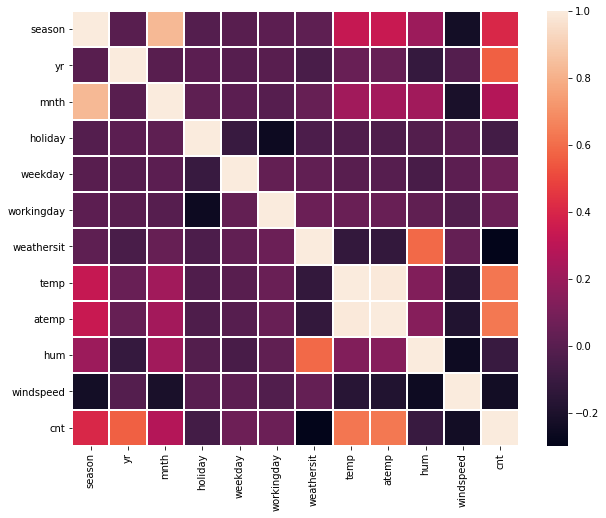

<Figure size 432x288 with 0 Axes>

In [10]:
data.plot_correlation()
plt.savefig('corr.png')

#### Distribuition of the target value

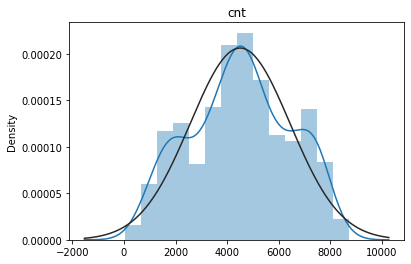

In [11]:
sns.distplot(x = df['cnt'] , fit=stats.norm)
plt.title('cnt')
plt.savefig('target0.png')

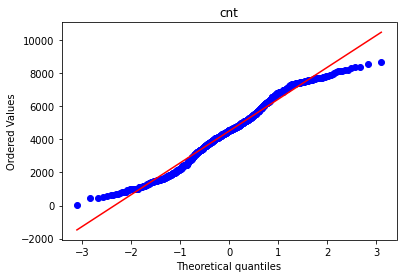

In [12]:
_=stats.probplot(df['cnt'], plot=plt)
plt.title('skew='+'{:.4f}'.format(stats.skew(df['cnt'])))
plt.title('cnt')
plt.savefig('target.png')

#### Distribuition of continuous features and its correlation with the target 

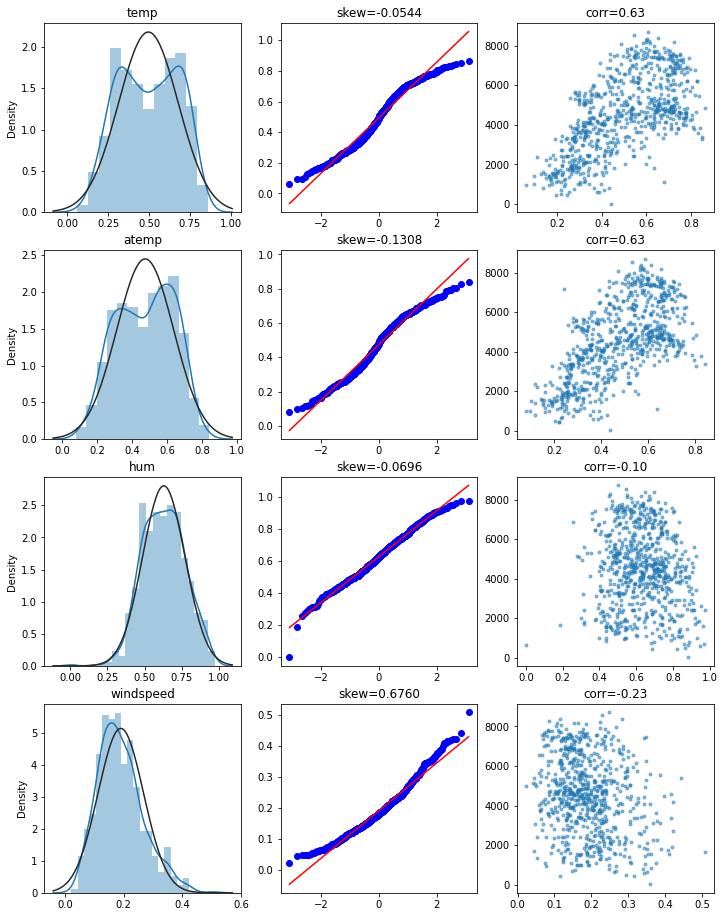

In [13]:
# Look the distribuition and how the numeric variables and its correlation with the rented bikes
cols = num_columns
target = df.cnt
fcols = 3
frows = len(cols)
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols:
    if var!='cnt':
        dat = df[[var, 'cnt']]
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var)
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['cnt'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['cnt'])[0][1]))
        plt.savefig('counts.png')

*Both temp and atemp are very correlated with the bikes counts per day**


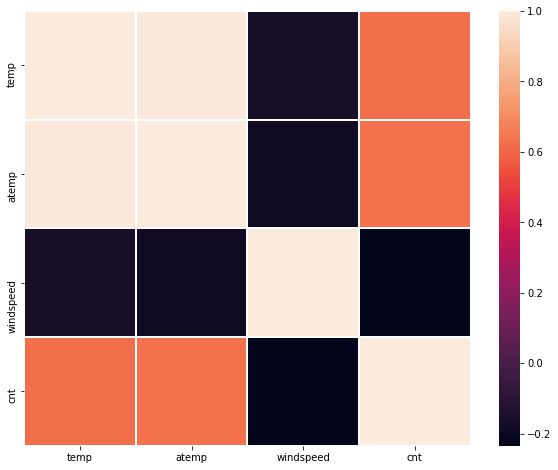

In [14]:
# zoom in temp and atemp
corrMatrix = df[['temp', 'atemp', 'windspeed' , 'cnt']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corrMatrix, annot=False,  linewidths=1)
plt.savefig('coor2.png')
plt.show()

**Temp and Atemp are very similar and close correlated with cnt.**

It is expected as temp is the normalized temperature and atemp is the real feeling.

Windspeed is negative correlated with cnt, some people avoind getting a bike when is wind

#### Spread of the categorical variables 

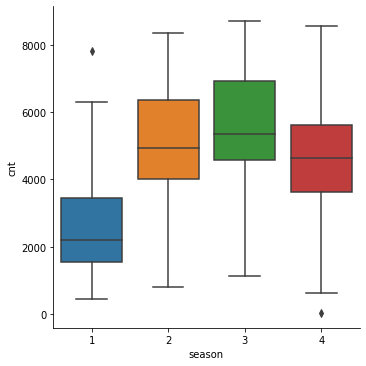

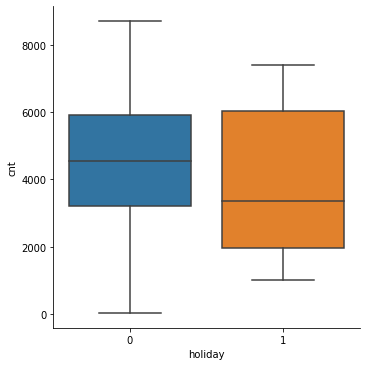

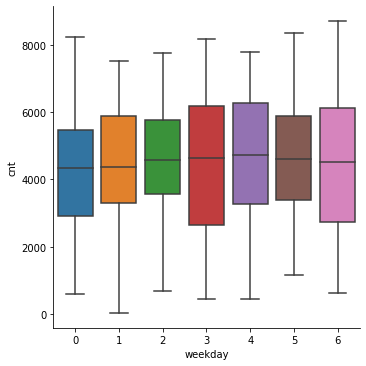

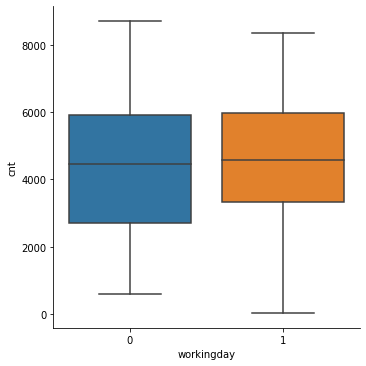

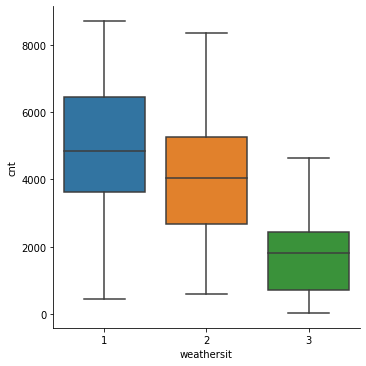

In [15]:
for cat in cat_columns:
    sns.catplot(x = df[cat] , y="cnt" , data=df, kind="box")
    plt.savefig(f'cat.png')

#### Scale the continuous variables to be between 0-1

In [21]:
df.dtypes

dteday        datetime64[ns]
season              category
yr                     int64
mnth                   int64
holiday             category
weekday             category
workingday          category
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
dtype: object

In [55]:
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,6,0,2,-0.826662,-0.679946,1.250171,-0.387892,985
1,2011-02-01,1,0,1,0,0,0,2,-0.721095,-0.740652,0.479113,0.749602,801
2,2011-03-01,1,0,1,0,1,1,1,-1.634657,-1.749767,-1.339274,0.746632,1349
3,2011-04-01,1,0,1,0,2,1,1,-1.614780,-1.610270,-0.263182,-0.389829,1562
4,2011-05-01,1,0,1,0,3,1,1,-1.467414,-1.504971,-1.341494,-0.046307,1600


**There is a tendency to reduce the number of bikes when the weather situation get worst**

Weathersit
1. Clear, Few clouds, Partly cloudy, Partly cloudy
2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog (not in this data)

## **Data quality report:**

1. **There is no null value in these dataset**
2. **The dteday variable was corrected to datetime**
3. **The continuous features are in the 0 to 1 range** 
4. **The categorical variables are all with the correct type**

# **2. Findind what factors impact on bike rentals**

Was shown on the exploratory analysis that some features are very correlated with the bike rental. To check what features can describe better, 2 methods will be used:

Method 1:
A series of linear regressions using all combination of features:

Method 2: 
Using 'Features importance from Xgboost regressor'

In [56]:
## check the feature importance based on simple regression:
data = Data(file1)
result = data.get_baseline_linear()

100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

Best columns for regression: ('season', 'yr', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed')
Validation score: 0.7834384465930762,	 Test score: 0.8173376263670762
tested in 80 data points


In [57]:
data = Data(file2)
result = data.get_baseline_linear()

100%|██████████| 10/10 [00:16<00:00,  1.60s/it]

Best columns for regression: ('season', 'yr', 'hr', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed')
Validation score: 0.39421158341063234,	 Test score: 0.3849285022442347
tested in 1893 data points


(It is interesting to see that temperature gives a little better result than temperature feeling)

In [58]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.inspection import permutation_importance

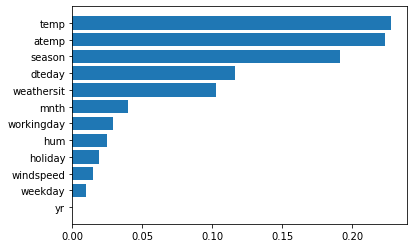

In [59]:
df = pd.read_csv(file1, parse_dates=['dteday'])
df.drop('instant', axis=1, inplace=True)
df['dteday'] = pd.to_numeric(df.dteday)
target = df['cnt']
data = df.drop('cnt', axis=1)
X_train, X_val, y_train, y_val = train_test_split(data.values, target, test_size=0.25,random_state=42)

# run XGboost
xgb = XGBRegressor(n_estimators=300)
xgb.fit(X_train, y_train)
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(data.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.savefig('most_imp.png')

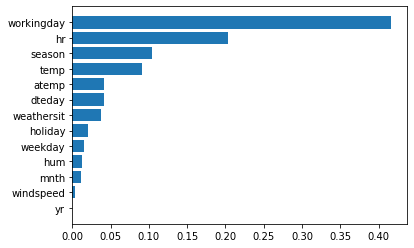

In [60]:
df = pd.read_csv(file2, parse_dates=['dteday'])
df.drop('instant', axis=1, inplace=True)
df['dteday'] = pd.to_numeric(df.dteday)
target = df['cnt']
data = df.drop('cnt', axis=1)
X_train, X_val, y_train, y_val = train_test_split(data.values, target, test_size=0.25,random_state=42)

# run XGboost
xgb = XGBRegressor(n_estimators=300)
xgb.fit(X_train, y_train)
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(data.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.savefig('most_imp2.png')

#### **Based on these analysis and the exploratory analysis, the most impact factor on bike rentals daily is the Temperature, however, when looking for the same data but sampled in hours, the most important feature is working day**


# ***3. Predict the number of bikes will be rented daily and hourly***

#### Method 1: Simple regressor

100%|██████████| 9/9 [00:02<00:00,  3.34it/s]


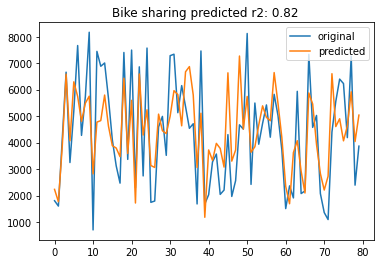

Best columns for regression: ('season', 'yr', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed')
Validation score: 0.7834384465930762,	 Test score: 0.8173376263670762
tested in 80 data points


{'val': 0.7834384465930762, 'test': 0.8173376263670762}

In [61]:
# daily 
data = Data(file1)
data.get_baseline_linear(plot=True, savefig=True)

100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


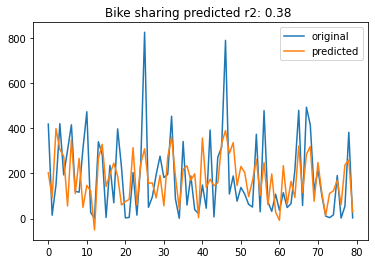

Best columns for regression: ('season', 'yr', 'hr', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed')
Validation score: 0.39421158341063234,	 Test score: 0.3849285022442347
tested in 1893 data points


{'val': 0.39421158341063234, 'test': 0.3849285022442347}

In [62]:
data = Data(file2)
data.get_baseline_linear(plot=True, savefig=True)

Although the simple regressor could get a r^2 score of 0.78 in daily counts, the same model failed in the hourly data.

#### Method 2: Xgboost Regressor

In [63]:
df = pd.read_csv(file1, parse_dates=['dteday'])
df.drop('instant', inplace=True, axis=1)

df['dteday'] = pd.to_numeric(df.dteday)
target = df['cnt']
data = df.drop('cnt', axis=1)

X_train, X_test_val, y_train, y_test_val = train_test_split(data.values, target, test_size=.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=.33, random_state=42)

# run XGboost
xgb = XGBRegressor(n_estimators=200)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
r2 = r2_score(y_val, y_pred)
print(f'Val r2_score: {r2:.4f}')

y_pred = xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Test r2_score: {r2:.4f}')

Val r2_score: 0.8492
Test r2_score: 0.9336


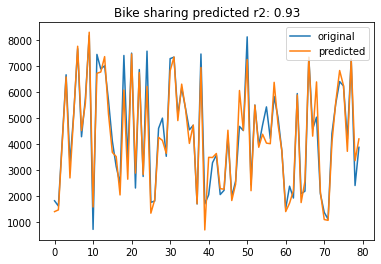

In [64]:
 x_ax = range(len(y_test[-80:]))
plt.plot(x_ax, y_test[-80:], label="original")
plt.plot(x_ax, y_pred[-80:], label="predicted")
plt.title(f'Bike sharing predicted r2: {r2:.2f}')
plt.legend()
plt.savefig('xgb_model0.png')
plt.show()


In [65]:
df = pd.read_csv(file2, parse_dates=['dteday'])
df.drop('instant', inplace=True, axis=1)

df['dteday'] = pd.to_numeric(df.dteday)
target = df['cnt']
data = df.drop('cnt', axis=1)
X_train, X_test_val, y_train, y_test_val = train_test_split(data.values, target, test_size=.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=.33, random_state=42)

# run XGboost
xgb = XGBRegressor(n_estimators=200)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
r2 = r2_score(y_val, y_pred)
print(f'Val r2_score: {r2:.4f}')

y_pred = xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Test r2_score: {r2:.4f}')

Val r2_score: 0.9550
Test r2_score: 0.9518


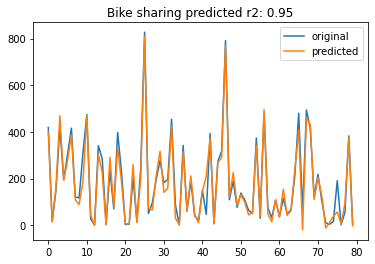

In [66]:
x_ax = range(len(y_test[-80:]))
plt.plot(x_ax, y_test[-80:], label="original")
plt.plot(x_ax, y_pred[-80:], label="predicted")
plt.title(f'Bike sharing predicted r2: {r2:.2f}')
plt.legend()
plt.savefig('xgb_model1.png')
plt.show()

# Conclusion:

### The bike amount of bikes that are rented per day can be predicted with a r2 score of 92%. When using data sampled by hour the amount of bikes can be predicted with r2 score of 95%.